In [1]:
import numpy as np
# import pyedflib
from matplotlib import pyplot as plt
# from nitime import utils
# from nitime import algorithms as alg
# from nitime.timeseries import TimeSeries
# from nitime.viz import plot_tseries
import csv
import pywt
import scipy.stats as sp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import signal
# from spectrum import *
from os import listdir
from os.path import isfile, join
from wyrm import processing as proc
from wyrm.types import Data
from wyrm.io import convert_mushu_data
from sklearn import metrics
# from wyrm.processing import calculate_csp,segment_dat,apply_csp,append_epo
# from wyrm.processing import select_channels
# from wyrm.processing import swapaxes
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import OrthogonalMatchingPursuit
# from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.preprocessing import normalize
# from scipy.fftpack import fft
from scipy.fftpack import dct
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold

In [2]:
channels = ['Fp1', 'AFp1', 'Fpz', 'AFp2', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'FAF5', 'FAF1', 'FAF2', 'FAF6', 
                'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FFC7', 'FFC5', 'FFC3', 'FFC1', 'FFC2', 'FFC4', 
                'FFC6', 'FFC8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'CFC7', 
                'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6'
                , 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1',
                'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'PCP7', 'PCP5', 'PCP3', 'PCP1', 'PCP2', 'PCP4', 'PCP6', 'PCP8', 
                'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PPO7', 'PPO5', 'PPO1', 'PPO2', 'PPO6',
                'PPO8', 'PO7', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO8', 'OPO1', 'OPO2', 'O1', 'Oz', 'O2', 'OI1', 'OI2', 
                'I1', 'I2']

getrawdata() function - Takes in the .txt files for the data series and the markers of a particular subject.

In [3]:
def getrawdaata(training_data,markers):
    signal_array = [list(map(float,l.split())) for l in open(training_data).readlines()]
    signal_array = np.array(signal_array)
    marker_array = [list(map(str,l.split())) for l in open(markers).readlines()]
    marker_array = np.array(marker_array)
    return signal_array,marker_array

In [4]:
def add_datapoints(marker_array):
    train_markers2 = []
    for events in marker_array:
        if events[1]!= 0:
            train_markers2.append((float(events[0]), str(events[1])))
            train_markers2.append((float(events[0]) + 50.0, str(events[1])))
            train_markers2.append((float(events[0]) + 100.0, str(events[1])))
            train_markers2.append((float(events[0]) + 150.0, str(events[1])))
            train_markers2.append((float(events[0]) + 200.0, str(events[1])))
            train_markers2.append((float(events[0]) + 250.0, str(events[1])))
            train_markers2.append((float(events[0]) + 300.0, str(events[1])))
    return np.array(train_markers2)

In [5]:
def segment_data(data,markers):
    marker = np.array(markers)
    arr = []
    for i in markers:
        temp = []
        for j in range(-1,49):
            temp.append(np.array(data[int(i[0])+j]))
        temp = np.array(temp)
        arr.append(temp)
    arr = np.array(arr)
    return arr

In [6]:
def mapdata(train_markers2,signal_array):
    markers_subject1_class_1 = [(float(events[0]),events[1]) for events in train_markers2 if events[1]== '1']
    markers_subject1_class_2 = [(float(events[0]),events[1]) for events in train_markers2 if events[1]== '2']
    cnt1 = convert_mushu_data(signal_array, markers_subject1_class_1,50,channels)
    cnt2 = convert_mushu_data(signal_array, markers_subject1_class_2,50,channels)
    class1 = segment_data(cnt1.data,cnt1.markers)
    class2 = segment_data(cnt2.data,cnt2.markers)
    data = np.concatenate([class1,class2],axis=0)
    #-------------- TARGET ARRAY------------------
    target1 = [1 for element in range(len(class1))]
    target2 = [2 for element in range(len(class2))]
    Target = np.concatenate((target1,target2))
    return data,Target

In [7]:
def bandpowers(segment):
    alpha = []
    beta = []
    for i in range(len(segment)):
        f,Psd = signal.welch(segment[i], 100)
        power1 = 0
        power2 = 0
        for j in range(0,len(f)):
            if(f[j]>=4 and f[j]<=13):
                power1 += Psd[j]
            if(f[j]>=14 and f[j]<=30):
                power2 += Psd[j]
        alpha.append(power1)
        beta.append(power2)
    alpha = np.array(alpha)
    beta = np.array(beta)
    return alpha,beta

In [8]:
def dct_features(segment):
    features = []
    for i in range(len(segment)):
        dct_coef = dct(segment[i,:], 2, norm='ortho')
        power = sum( j*j for j in dct_coef)
        features.append(power)
    return features

In [9]:
def wavelet_features(segment):
    cA_values = []
    cD_values = []
    cA_Energy =[]
    cD_Energy = []
    for i in range(len(segment)):
        cA,cD=pywt.dwt(segment[i,:],'coif1')
        cA_values.append(cA)
        cD_values.append(cD)
    for x in range(len(segment)):
        cA_Energy.append(abs(np.sum(np.square(cA_values[x]))))
    for x in range(len(segment)):
        cD_Energy.append(abs(np.sum(np.square(cD_values[x]))))
    cA_Energy = np.array(cA_Energy)
    cD_Energy = np.array(cD_Energy)
    return cA_Energy,cD_Energy

In [10]:
def extract_features(data):
    features_band_power_feature1 = []
    features_band_power_feature2 = []
    features_wavelet_feature1 = []
    features_wavelet_feature2 = []
    features_dct = []
    for i in range(len(data)):
        segment = data[i]
        segment = np.array(segment)
        segment = np.transpose(segment)
        features1a,features1b = bandpowers(segment)
        features_band_power_feature1.append(features1a)
        features_band_power_feature2.append(features1b)
        features2a,features2b  = wavelet_features(segment)
        features_wavelet_feature1.append(features2a)
        features_wavelet_feature2.append(features2b)
        features3 = dct_features(segment)
        features_dct.append(features3)
    features_band_power_feature1 = np.array(features_band_power_feature1)
    features_band_power_feature2 = np.array(features_band_power_feature2)
    features_wavelet_feature1 = np.array(features_wavelet_feature1)
    features_wavelet_feature2 = np.array(features_wavelet_feature2)
    features_dct = np.array(features_dct)
    return features_band_power_feature1,features_band_power_feature2,features_wavelet_feature1,features_wavelet_feature2,features_dct

Subject :  aa


c:\Users\Saathvika\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000024404078E20>


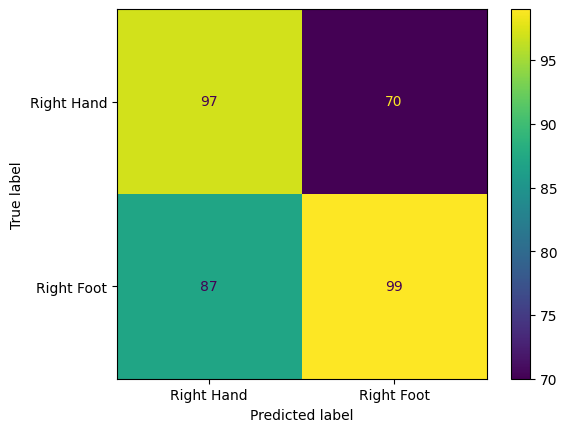

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002448A5BC8E0>


0.5382436260623229      0.5552407932011332      0.5552407932011332


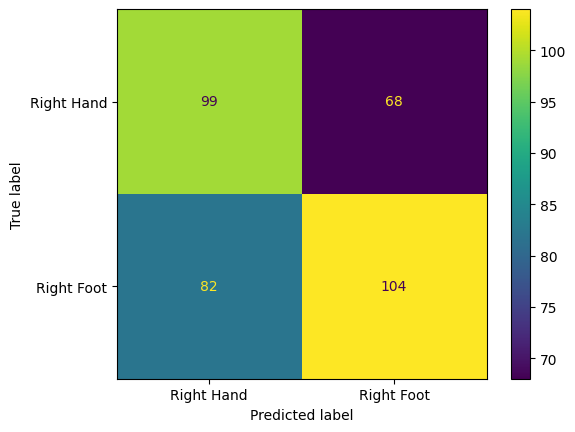

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002440415DDB0>


0.5920679886685553      0.5750708215297451      0.5750708215297451


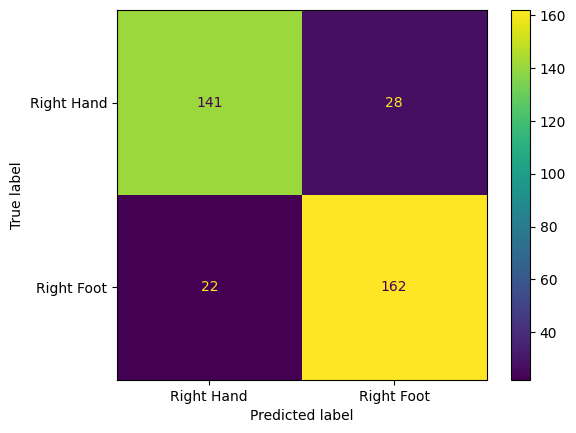

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002440420E7D0>


0.8101983002832861      0.8583569405099151      0.8583569405099151


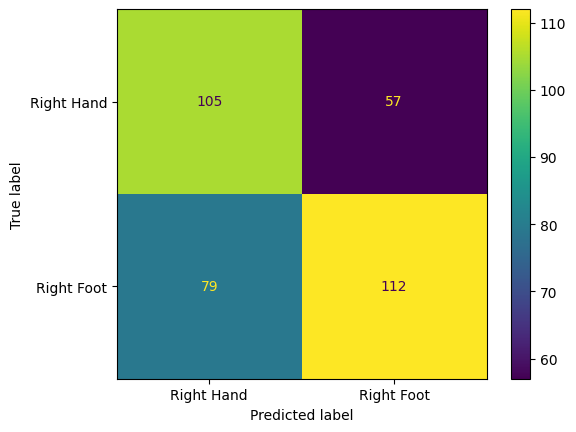

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002447FB26890>


0.6203966005665722      0.6147308781869688      0.6147308781869688


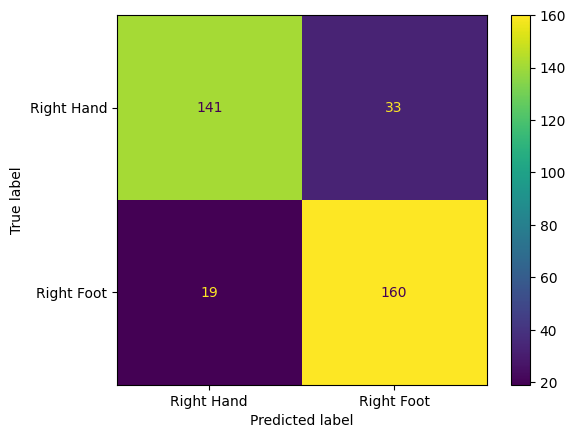

0.7875354107648725      0.8526912181303116      0.8526912181303116
Subject :  al


c:\Users\Saathvika\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002440420CD00>


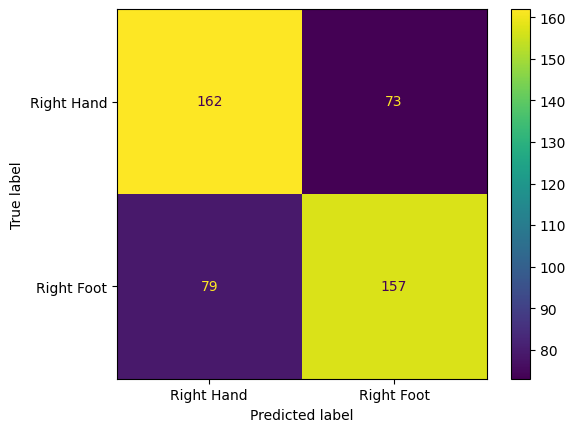

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002440418CA90>


0.6900212314225053      0.6772823779193206      0.6900212314225053


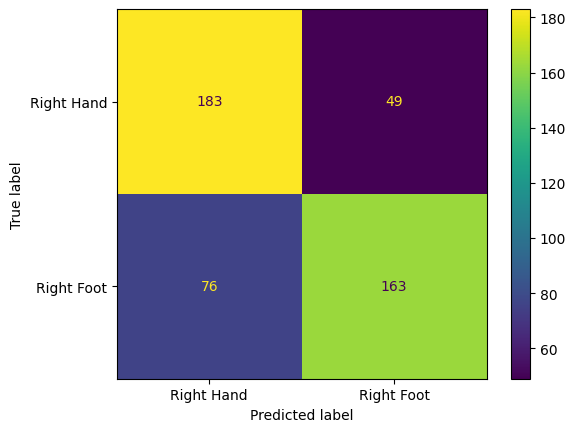

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000244040AD9F0>


0.7048832271762208      0.7346072186836518      0.7048832271762208


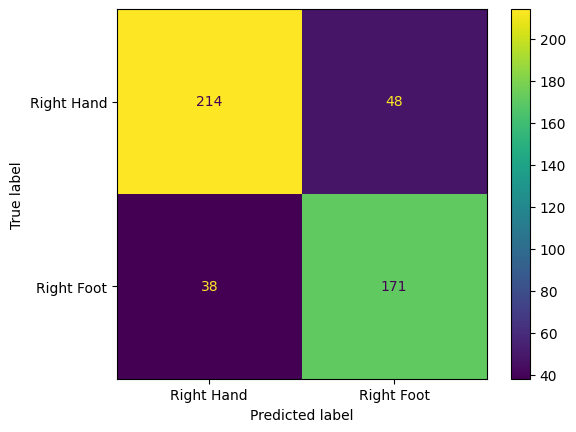

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002448A5A03D0>


0.7791932059447984      0.8174097664543525      0.8174097664543525


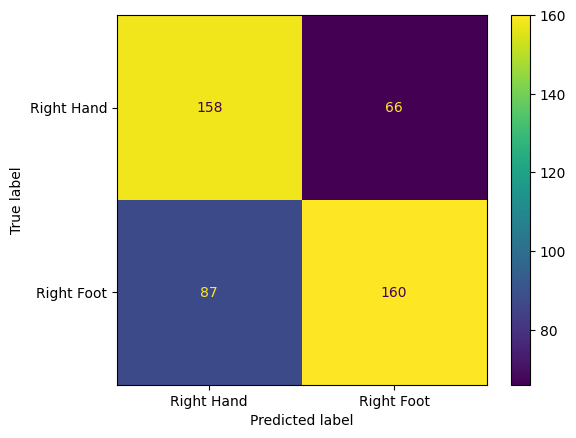

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002440416D150>


0.6411889596602972      0.6751592356687898      0.6411889596602972


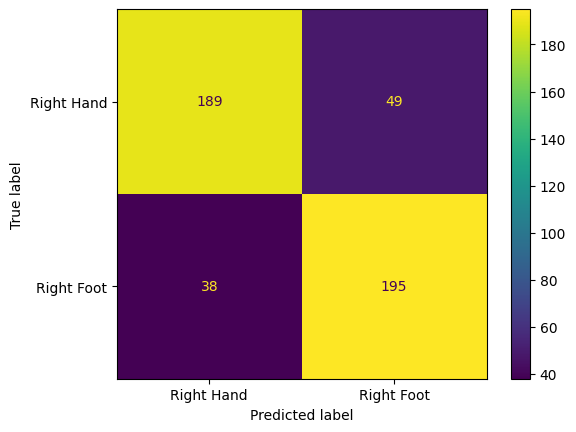

0.802547770700637      0.8152866242038217      0.8152866242038217
Subject :  av


c:\Users\Saathvika\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000024404199750>


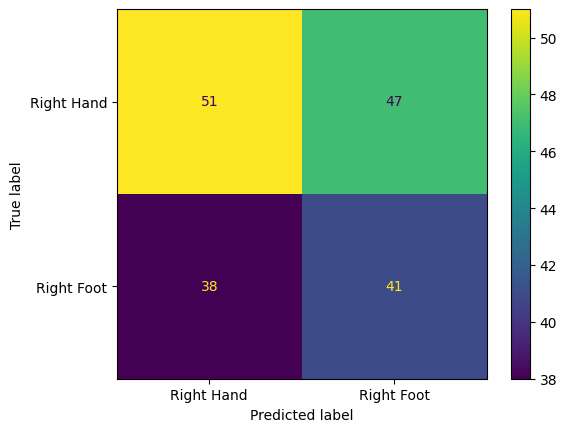

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002447FAF6080>


0.4971751412429379      0.519774011299435      0.519774011299435


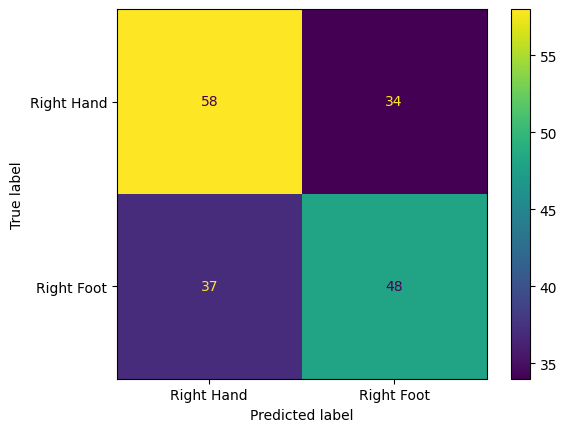

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002447FAB06D0>


0.5819209039548022      0.5988700564971752      0.5988700564971752


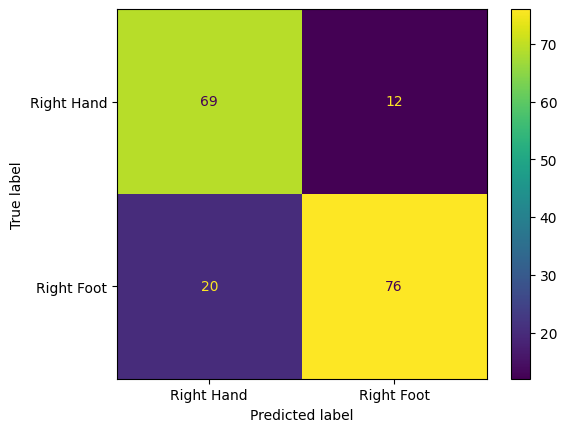

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002447FAB23E0>


0.8192090395480226      0.8192090395480226      0.8192090395480226


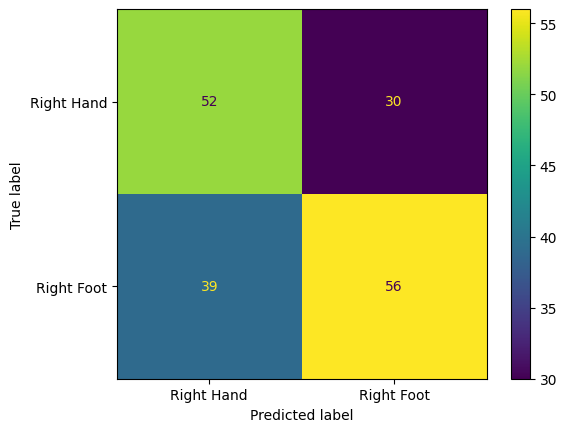

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000244041CA9E0>


0.5480225988700564      0.6101694915254238      0.5480225988700564


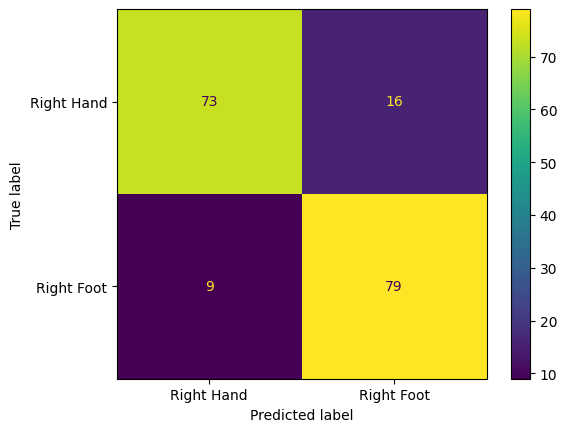

0.8418079096045198      0.8587570621468926      0.8418079096045198
Subject :  aw


c:\Users\Saathvika\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002447FB57E80>


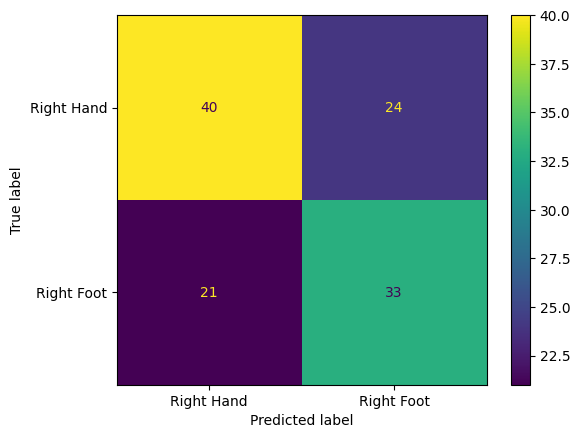

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000024403F470D0>


0.5847457627118644      0.6186440677966102      0.5847457627118644


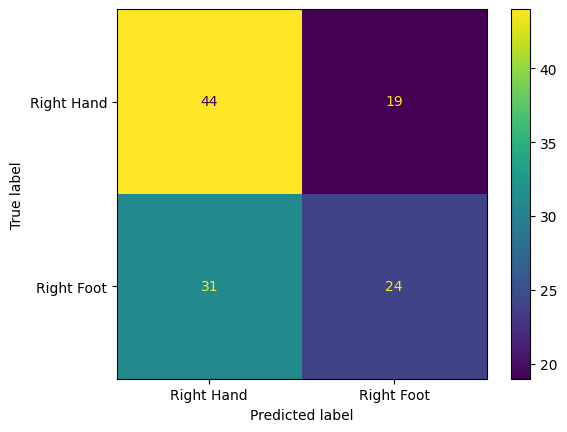

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002447FBA8E50>


0.6101694915254238      0.576271186440678      0.6101694915254238


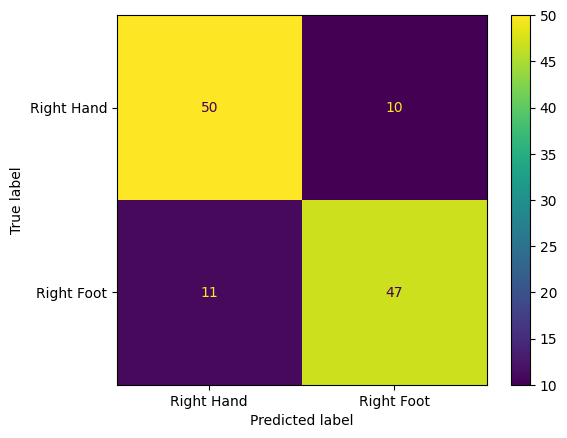

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002448A5A23E0>


0.8050847457627118      0.8220338983050848      0.8050847457627118


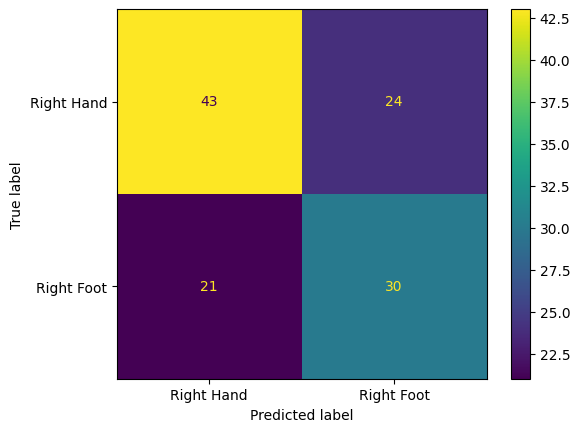

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002448A539F60>


0.5847457627118644      0.6186440677966102      0.5847457627118644


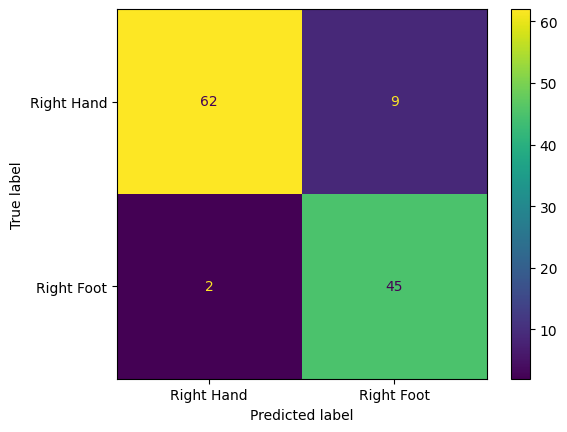

0.8728813559322034      0.9067796610169492      0.8728813559322034
Subject :  ay


c:\Users\Saathvika\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002448A5A3D30>


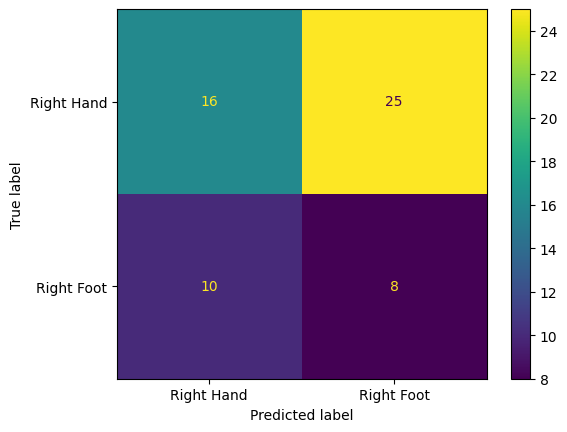

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002447FAF49A0>


0.4067796610169492      0.4067796610169492      0.4067796610169492


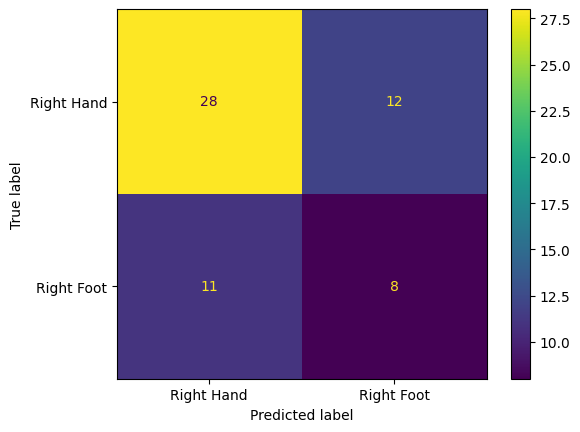

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002440418FF70>


0.6271186440677966      0.6101694915254238      0.6271186440677966


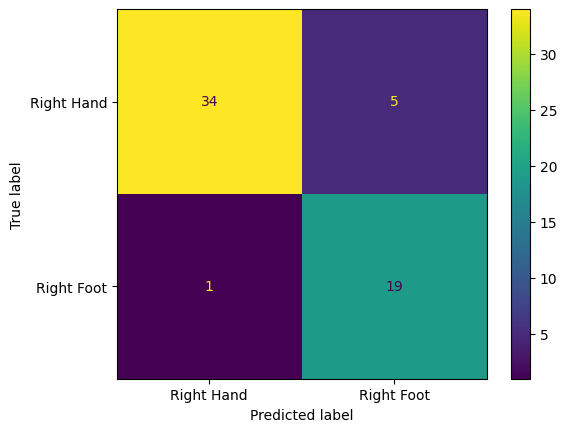

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002447FAB1270>


0.8983050847457628      0.8983050847457628      0.8983050847457628


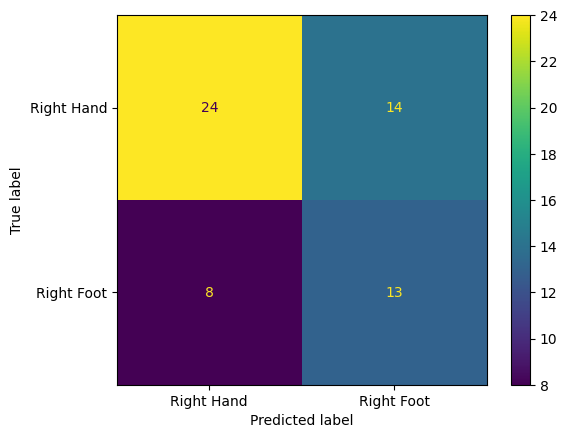

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002440400C520>


0.6271186440677966      0.6271186440677966      0.6271186440677966


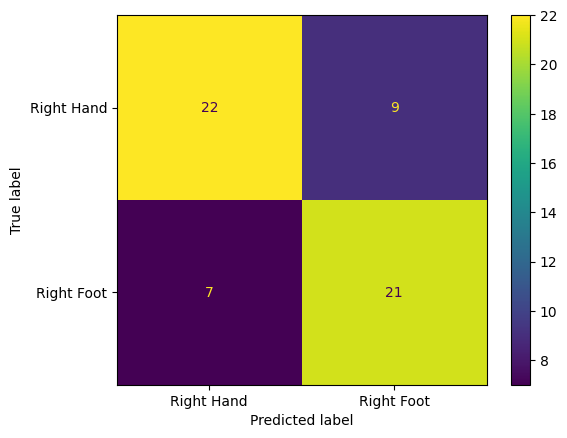

0.8135593220338984      0.7288135593220338      0.8135593220338984


In [11]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
subjects = ["aa","al","av","aw","ay"]
for i in subjects:
    print("Subject : ",i)
    training_data = i+'\data_set_IVa_'+i+'_cnt.txt'
    markers =i+'\data_set_IVa_'+i+'_mrk.txt'
    signal_array,marker_array = getrawdaata(training_data,markers)
    marker_array = add_datapoints(marker_array)
    data,target = mapdata(marker_array,signal_array)
    f_bandpower_1,f_bandpower_2,f_wavelet_1,f_wavelet_2,f_dct = extract_features(data)
    features = [f_bandpower_1,f_bandpower_2,f_wavelet_1,f_wavelet_2,f_dct]
    for f in features:
        # print("Feature : ",features.index[f])
        # Train-Test-Split
        x_train,x_test,y_train,y_test = train_test_split(f,target,test_size = 0.3,shuffle = 30)
        #Linear Discriminant Analysis for Data preprocessing
        lda = LinearDiscriminantAnalysis(n_components=1)
        x_train = lda.fit_transform(x_train, y_train)
        x_test = lda.transform(x_test)
        #Initialising the models
        kf = KFold(n_splits=5,random_state = 30, shuffle = True)
        SVM_cla = SVC(kernel='poly', random_state=0)
        classifier1 = SVC(kernel='poly', random_state=0)
        Logistic_Reg = LogisticRegression()
        classifier2 = LogisticRegression()
        model = VotingClassifier(estimators=[('sv', classifier1), ('lr', classifier2)], voting='hard')
        #SVM Classifier
        #Training SVM model
        for train_index, test_index in kf.split(x_train):
            X_train, X_test = x_train[train_index], x_train[test_index]
            Y_train, Y_test = y_train[train_index], y_train[test_index]
            SVM_cla.fit(X_train,Y_train)
            y_pred_temp = SVM_cla.predict(X_test)
            # print(accuracy_score( Y_test, y_pred))
        #Testing SVM Model
        y_pred_SVM = SVM_cla.predict(x_test)
        confusion_matrix_SVM = metrics.confusion_matrix(y_test,y_pred_SVM)
        # cm_display_SVM = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_SVM, display_labels = ["Right Hand", "Right Foot"])
        # cm_display_SVM.plot()
        # plt.show()

        #Logistic Regression CLassifier
        #Training LR Classifier
        for train_index, test_index in kf.split(x_train):
            X_train, X_test = x_train[train_index], x_train[test_index]
            Y_train, Y_test = y_train[train_index], y_train[test_index]
            Logistic_Reg.fit(X_train,Y_train)
            y_pred_temp = Logistic_Reg.predict(X_test)
            # print(accuracy_score( Y_test, y_pred))
        #Testing LR CLassifier
        y_pred_Logistic = Logistic_Reg.predict(x_test)
        confusion_matrix_LR = metrics.confusion_matrix(y_test,y_pred_Logistic)
        cm_display_LR= metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_LR, display_labels = ["Right Hand", "Right Foot"])
        cm_display_LR.plot()
        plt.show()

        #Ensembling Model(Voting Classifier)
        #Training EM Model
        for train_index, test_index in kf.split(x_train):
            X_train, X_test = x_train[train_index], x_train[test_index]
            Y_train, Y_test = y_train[train_index], y_train[test_index]
            model.fit(X_train,Y_train)
            # print(model.score(X_test,Y_test))
        #Testing the classifier 
        print(accuracy_score(y_test, y_pred_SVM),"    " , accuracy_score(y_test, y_pred_Logistic), "    " , model.score(x_test,y_test))
        confusion_matrix_SVM = metrics.confusion_matrix(y_test,model.predict(x_test))
        # cm_display_SVM = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_SVM, display_labels = ["Right Hand", "Right Foot"])
        # cm_display_SVM.plot()
        # plt.show()